In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import pulp
import random

In [2]:
df = pd.read_csv(r"C:\Users\gudal\Downloads\ambulace optimization\extracted_data\final.csv")
accident_df = df[df['class'] == 1].copy()
accident_coords = accident_df[['latitude', 'longitude']].values

In [3]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

In [4]:
def optimize_ambulance_locations(station_coords, accident_coords, max_ambulances, station_capacity):
    num_stations = len(station_coords)
    num_accidents = len(accident_coords)

    # Travel time matrix
    travel_time = np.zeros((num_stations, num_accidents))
    for i, (s_lat, s_lon) in enumerate(station_coords):
        for j, (a_lat, a_lon) in enumerate(accident_coords):
            dist_km = haversine(s_lat, s_lon, a_lat, a_lon)
            travel_time[i][j] = (dist_km / 40) * 60  # 40 km/h avg speed

    model = pulp.LpProblem("Ambulance_Optimization", pulp.LpMinimize)
    x = pulp.LpVariable.dicts("Place", range(num_stations), cat='Binary')
    y = pulp.LpVariable.dicts("Assign", [(i, j) for i in range(num_stations) for j in range(num_accidents)], cat='Binary')

    # Objective
    model += pulp.lpSum([travel_time[i][j] * y[(i, j)] for i in range(num_stations) for j in range(num_accidents)])

    # Constraints
    model += pulp.lpSum([x[i] for i in range(num_stations)]) == max_ambulances
    for j in range(num_accidents):
        model += pulp.lpSum([y[(i, j)] for i in range(num_stations)]) == 1
    for i in range(num_stations):
        for j in range(num_accidents):
            model += y[(i, j)] <= x[i]
    for i in range(num_stations):
        model += pulp.lpSum([y[(i, j)] for j in range(num_accidents)]) <= station_capacity

    # Solve
    model.solve()

    # Collect results
    assignments = {}
    for j in range(num_accidents):
        for i in range(num_stations):
            if pulp.value(y[(i, j)]) == 1:
                assignments[j] = (i, travel_time[i][j])
    return assignments, station_coords


In [5]:
def generate_random_stations(accident_coords, num_stations):
    return random.sample(list(accident_coords), num_stations)

In [6]:
num_stations = 10
max_ambulances = 50
station_capacity = 100

# (A) Optimized station placement using KMeans
kmeans = KMeans(n_clusters=num_stations, random_state=42).fit(accident_coords)
optimized_stations = kmeans.cluster_centers_
opt_assignments, opt_coords = optimize_ambulance_locations(optimized_stations, accident_coords, max_ambulances, station_capacity)

# (B) Baseline: Random station placement
random_stations = generate_random_stations(accident_coords, num_stations)
base_assignments, base_coords = optimize_ambulance_locations(random_stations, accident_coords, max_ambulances, station_capacity)

In [ ]:
def analyze(assignments):
    times = [time for _, time in assignments.values()]
    return {
        "Avg Travel Time (min)": np.mean(times),
        "Max Travel Time (min)": np.max(times),
        "Min Travel Time (min)": np.min(times)
    }

opt_result = analyze(opt_assignments)
base_result = analyze(base_assignments)

print("\n Optimized Model Performance:")
print(opt_result)

print("\n Baseline (Random) Model Performance:")
print(base_result)


 Optimized Model Performance:
{'Avg Travel Time (min)': np.float64(8.053356728245113), 'Max Travel Time (min)': np.float64(24.984423242553365), 'Min Travel Time (min)': np.float64(2.0383700205072053)}

 Baseline (Random) Model Performance:
{'Avg Travel Time (min)': np.float64(7.658798979191563), 'Max Travel Time (min)': np.float64(114.80633253191385), 'Min Travel Time (min)': np.float64(0.12577708286460787)}


C:\Users\gudal\AppData\Local\Temp\ipykernel_31416\2268303356.py:41: UserWarning: Glyph 128657 (\N{AMBULANCE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\gudal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128657 (\N{AMBULANCE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


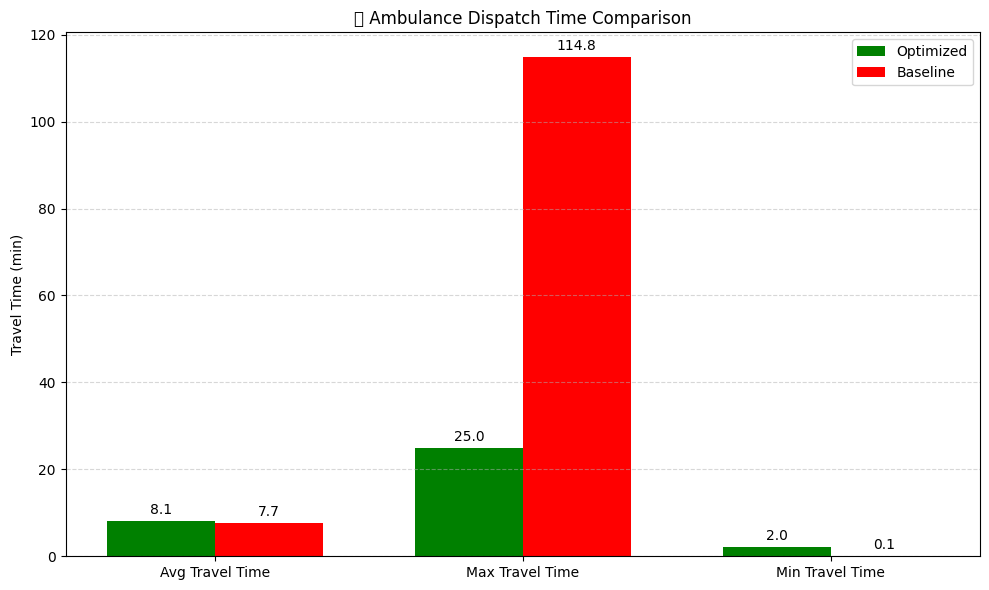

In [ ]:
import matplotlib.pyplot as plt

# Prepare data
labels = ['Avg Travel Time', 'Max Travel Time', 'Min Travel Time']
optimized_values = [float(opt_result['Avg Travel Time (min)']),
                    float(opt_result['Max Travel Time (min)']),
                    float(opt_result['Min Travel Time (min)'])]

baseline_values = [float(base_result['Avg Travel Time (min)']),
                   float(base_result['Max Travel Time (min)']),
                   float(base_result['Min Travel Time (min)'])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # width of the bars

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, optimized_values, width, label='Optimized', color='green')
bars2 = ax.bar(x + width/2, baseline_values, width, label='Baseline', color='red')

# Add labels, title and custom x-axis tick labels
ax.set_ylabel('Travel Time (min)')
ax.set_title(' Ambulance Dispatch Time Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [15]:
# Find the accident with the maximum travel time
worst_case = max(base_assignments.items(), key=lambda item: item[1][1])  # (acc_idx, (station_idx, travel_time))

# Unpack properly
acc_idx, (station_idx, travel_time) = worst_case

# Print details
print(f" Accident #{acc_idx} is assigned to Station #{station_idx}")
print(f" Travel Time: {travel_time:.2f} minutes")


 Accident #1467 is assigned to Station #5
 Travel Time: 114.81 minutes
